# Analiza korisnika i zadataka na platformi RingZer0

In [1]:
import pandas as pd
import requests

import numpy as np

In [2]:
# Funkcija za zvati api sa kompletnim error handlingom
import time

def call_api(url):
    for attempt in range(3): 
        try:
            response = requests.get(url, timeout=5)
            if response.status_code == 200:
                return response.json()
            elif response.status_code == 429:  # Rate Limit
                time.sleep(2 ** attempt)
            else:
                time.sleep(1)
        except Exception as e:
            print(f"API call failed: {e}")
            time.sleep(2 ** attempt)  # Exponential backoff
    return None

## Prikupljanje podataka o kategorijama

Prvo želimo prikupiti sve kategorije u RingZero i prebaciti ih u standardne jeopardy kategorije.

In [ ]:
# Prikupi info o kategorijama 
url = "https://ringzer0ctf.com/api/categories"
response = requests.get(url)
data = response.json()

# Prikupi sve category id-jeve
categories = data['data']['categories']
category_ids = [cat['category']['id'] for cat in categories]
category_titles = [cat['category']['title'] for cat in categories]
print(f"Found {len(category_ids)} categories: {category_ids}")  
print(f"Category titles: {category_titles}")

Found 21 categories: ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21']
Category titles: ['SQL Injection', 'Reverse Engineering', 'Steganography', 'Forensics', 'Coding Challenges', 'Cryptography', 'JavaScript', 'Web', 'Pwnage Linux', 'SysAdmin Linux', 'Jail Escaping', 'Shellcoding', 'Malware Analysis', 'The NC8 Reverse Engineering Track', 'Exotic Data Storage', 'Software Defined Radio', 'NorthSec 2021', 'NorthSec 2023', 'NorthSec 2022', 'NorthSec 2024', 'NorthSec 2025']


In [2]:
category_ids = ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21']
category_titles = ['SQL Injection', 'Reverse Engineering', 'Steganography', 'Forensics', 'Coding Challenges', 'Cryptography', 'JavaScript', 'Web', 'Pwnage Linux', 'SysAdmin Linux', 'Jail Escaping', 'Shellcoding', 'Malware Analysis', 'The NC8 Reverse Engineering Track', 'Exotic Data Storage', 'Software Defined Radio', 'NorthSec 2021', 'NorthSec 2023', 'NorthSec 2022', 'NorthSec 2024', 'NorthSec 2025']

categories = {"Web": ["SQL Injection", "JavaScript", "Web"],
              "Rev": ["Reverse Engineering", "The NC8 Reverse Engineering Track"], 
              "Pwn": ["Pwnage Linux", "Jail Escaping", "Shellcoding", "Malware Analysis"], 
              "Crypt": ["Cryptography"], 
              "Forensics": ["Forensics", "Exotic Data Storage", "Steganography"], 
              "Misc": ["Software Defined Radio", "SysAdmin Linux", "Coding Challenges"], 
              "Special": ["NorthSec 2021", "NorthSec 2022", "NorthSec 2023", "NorthSec 2024", "NorthSec 2025"]}

Struktura tablica za podatke

In [ ]:
# Tables content
# users_df = pd.DataFrame(columns=["id", "username", "isRCEH", "country", "joined_date", "last_date", "points"	"rank"]) 
# challenges_df = pd.DataFrame(columns=["category_id", "category_title", "challenge_id", "challenge_title", "points"])
# solves_df = pd.DataFrame(columns=["user_id", "challenge_id", "solve_date"])

## Prikupljanje postojećih challenga na stranici

In [ ]:
# 419 chals 11.9.2025.
challenge_list = []
for cat_id in category_ids:
    url = f"https://ringzer0ctf.com/api/category/challenges/{cat_id}"
    response = call_api(url)
    if response is None:
        print(f"Failed to retrieve data for category {cat_id}")
        continue
    cat_data = response.json()['data']['categories'][0]['category']
    for challenge in cat_data['challenges']:
        challenge_row = {
            'category_id': cat_id,
            'category_title': cat_data['title'],
            'challenge_id': challenge['challenge']['id'],
            'challenge_title': challenge['challenge']['title'],
            'challenge_points': challenge['challenge']['points']
        }
        challenge_list.append(challenge_row)


In [ ]:
challenges_df = pd.DataFrame(challenge_list)
challenges_df.to_csv('challenges.csv', index=False)
print(f"Challenges saved to challenges.csv ({len(challenge_list)} challenges total)")
print(challenges_df.head())

In [ ]:
# učitati zadatke iz challenge.csv
challenges_df = pd.read_csv('challenges.csv')

U popis korisnika dodajem samo korisnike koji su riješili barem jedan zadatak

In [ ]:
# stanje users i solves tablice 11.9.2025.
# Prikupi info o svakom zadatku 419 poziva i stvaranje popisa korisnika
solve_nums = {}
users_set = set()
solves = []

#Dohvatiti sve ideve zadataka
challenge_ids = challenges_df['challenge_id'].tolist()

# Pomocu id-eva zadataka dohvatiti info o zadacima, korisnicim koji su ih rijesili i rjesenjima
for id in challenge_ids:
    url = f"https://ringzer0ctf.com/api/challenge/users/{id}"
    response = call_api(url)
    if response is None:
        print(f"Failed to retrieve data for challenge {id}")
        continue
    solve = response.json()['data']

    # za stvaranje solves_df = povezivanje korisnika i rjesenja zadataka
    solvers = solve['categories'][0]['category']['challenges'][0]['challenge']['Solvers']
    # u api dokumentaciji pise validation_time, ali je zapravo validationTime
    solves.extend([{
        "challenge_id": id,
        "user_id": s['Solver']['userId'],
        "validation_time": s['Solver']['validationTime']
    } for s in solvers])


    # za stvaranje users_df
    users_set.update([(u['user']['id'], u['user']['username'], u['user']['isRCEH'], u['user']['country']) for u in solve['users']])

    # za nadopunu broja rjesenja pojedinog zadatka u challenges_df
    solve_nums[id] = len(solve['users'])

In [ ]:
solve_df = pd.DataFrame(solves)
solve_df.head()
solve_df.to_csv('solves.csv', index=False)

In [ ]:
users_df = pd.DataFrame(list(users_set), columns=["id", "username", "isRCEH", "country"])
users_df.head()
users_df.to_csv('users.csv', index=False)

## Nadopuna Challenges tablice

In [ ]:
# challenges_df = pd.read_csv('challenges.csv')

In [ ]:
challenges_df["challenge_solves"] = challenges_df['challenge_id'].map(solve_nums)
challenges_df.head()

In [ ]:
subcategory_to_overarching = {}
for over_cat, subcats in categories.items():
    for subcat in subcats:
        subcategory_to_overarching[subcat] = over_cat
challenges_df["overarching_category"] = challenges_df["category_title"].map(subcategory_to_overarching)

In [ ]:
challenges_df.head()
challenges_df.to_csv('challenges1.csv', index=False)

## Nadopuna Users tablice

Sljedeći cell vrtila više puta za različite chunkove popisa da bih prikupila sve korisnike. 
prvi run do 4213
drugi run do 15xxx
treći run sa threadingom i boljim error handlingom do kraja

In [33]:
users_df = pd.read_csv('users1.csv')

In [26]:
import json
import concurrent
from tqdm import tqdm

def fetch_user(id):
    url = f"https://ringzer0ctf.com/api/user/info/{id}"
    response = call_api(url)
    # dodati error handling
    try:
        user_info = response['data']['users'][0]['user']
        return({
            "id": id,
            "joined_date": user_info['memberSince'],
            "last_date": user_info['lastFlag'],
            "points": user_info['points'],
            "rank": user_info['rank']
        })
    except (json.JSONDecodeError, Exception) as e:
        print(f"Error retrieving user info for ID {id}: {e}")

user_data = []
ids = users_df['id'].iloc[15740:]

with concurrent.futures.ThreadPoolExecutor(max_workers=10) as executor:
    results = executor.map(fetch_user, ids)
    for result in tqdm(results, total=len(ids)):
        if result is not None:
            user_data.append(result)


100%|██████████| 8773/8773 [10:22<00:00, 14.09it/s]


In [28]:
user_data

[{'id': 46062,
  'joined_date': '2023-07-31 07:56:44',
  'last_date': '2023-07-31 12:01:01',
  'points': '61',
  'rank': '1503'},
 {'id': 26265,
  'joined_date': '2019-01-13 07:11:33',
  'last_date': '2019-01-13 16:07:25',
  'points': '4',
  'rank': '13815'},
 {'id': 39788,
  'joined_date': '2021-07-25 02:52:08',
  'last_date': '2021-08-11 13:47:35',
  'points': '95',
  'rank': '876'},
 {'id': 51054,
  'joined_date': '2025-01-14 08:42:09',
  'last_date': '2025-01-14 08:50:21',
  'points': '2',
  'rank': '19763'},
 {'id': 2642,
  'joined_date': '2015-04-12 11:46:11',
  'last_date': '2015-04-12 12:30:12',
  'points': '1',
  'rank': '20193'},
 {'id': 48151,
  'joined_date': '2024-01-22 13:30:42',
  'last_date': '2024-01-22 13:54:21',
  'points': '3',
  'rank': '16769'},
 {'id': 8004,
  'joined_date': '2015-12-27 07:19:55',
  'last_date': '2016-01-08 05:42:45',
  'points': '27',
  'rank': '3374'},
 {'id': 8021,
  'joined_date': '2015-12-28 00:05:00',
  'last_date': '2016-02-08 00:08:50',
 

In [ ]:
user_update_df = pd.DataFrame(user_data)

users_df_indexed = users_df.set_index("id")
user_update_df_indexed = user_update_df.set_index("id")

# Combine, preferring non-null values from user_update_df
users_df_combined = users_df_indexed.combine_first(user_update_df_indexed).reset_index()
users_df_combined.head()

,id,country,isRCEH,joined_date,last_date,points,rank,username
0,6,Canada,False,2014-02-09 13:33:05,2016-02-10 23:23:06,118,661,ramsexy
1,10,Canada,False,2014-02-09 13:33:05,2014-02-06 20:20:24,3.0,14625.0,m6a2x6
2,11,Canada,False,2014-02-09 13:33:05,2014-02-23 02:17:15,18.0,4876.0,chaput
3,12,Canada,False,2014-02-09 13:33:05,2019-05-02 13:12:46,20.0,4472.0,mdube
4,14,Canada,False,2014-02-09 13:33:05,2014-09-04 17:44:52,55,1652,L30ballz


In [ ]:
users_df_combined.to_csv('users1.csv', index=False)
users_df = users_df_combined

# Analiza podataka

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns


In [4]:
challenges_df = pd.read_csv('challenges1.csv')
users_df = pd.read_csv('users1.csv')
solve_df = pd.read_csv('solves.csv')

Prosječna riješenost po kategoriji za sve korisnike

In [38]:
challenges_df.head()

,category_id,category_title,challenge_id,challenge_title,challenge_points,challenge_solves,overarching_category
0,1,SQL Injection,1,Most basic SQLi pattern.,1,10789,Web
1,1,SQL Injection,2,ACL rulezzz the world.,2,5323,Web
2,1,SQL Injection,3,Login portal 1,2,4211,Web
3,1,SQL Injection,171,Random Login Form,2,2581,Web
4,1,SQL Injection,21,Po po po po postgresql,2,2632,Web


In [39]:
avg_solve_rate_per_subcategory = challenges_df.groupby('category_title')['challenge_solves'].mean().reset_index()

In [40]:
print(avg_solve_rate_per_subcategory.sort_values(by='challenge_solves', ascending=False))

                       category_title  challenge_solves
5                          JavaScript       2767.300000
18                     SysAdmin Linux       1387.875000
14                      SQL Injection       1053.031250
0                   Coding Challenges        984.529412
3                           Forensics        773.607143
1                        Cryptography        744.555556
20                                Web        673.230769
17                      Steganography        609.800000
4                       Jail Escaping        467.714286
2                 Exotic Data Storage        438.000000
16             Software Defined Radio        252.000000
15                        Shellcoding        230.714286
13                Reverse Engineering        209.089286
12                       Pwnage Linux        136.142857
6                    Malware Analysis        117.090909
19  The NC8 Reverse Engineering Track         54.166667
7                       NorthSec 2021         49

A koje su to kategorije kad razmišljamo o standardnim jeopardy kategorijama?

In [41]:
avg_solve_rate_per_category = challenges_df.groupby('overarching_category')['challenge_solves'].mean().reset_index()
print(avg_solve_rate_per_category.sort_values(by='challenge_solves', ascending=False))

  overarching_category  challenge_solves
6                  Web       1025.297872
2                 Misc        970.000000
0                Crypt        744.555556
1            Forensics        678.210526
3                  Pwn        237.633803
4                  Rev        194.096774
5              Special         14.536232


Koji su najuspješniji korisnici i koliko im je dugo trebalo da dođu do trenutnog ranga?

Za izračunati period naći zadnji flag koji su submitali? Updated users table iznad tim informacijama

## Raspodjela bodova

In [17]:
print(users_df['points'].describe())

count    24512.000000
mean        19.445333
std         64.826171
min          1.000000
25%          2.000000
50%          5.000000
75%         14.000000
max       1745.000000
Name: points, dtype: float64


<Axes: ylabel='points'>

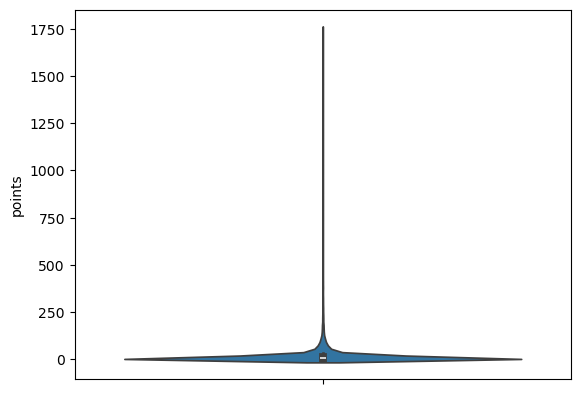

In [49]:
sns.violinplot(y=users_df['points'])

Želimo promatrati kako djeluju najbolji pa odjeljujemo top 10, 5, i 1% i dodatno top 30 igrača.

In [30]:
percentile_90 = users_df['points'].quantile(0.9)
percentile_95 = users_df['points'].quantile(0.95)
percentile_99 = users_df['points'].quantile(0.99)

print(f"90th percentile: {percentile_90}")
print(f"95th percentile: {percentile_95}")
print(f"99th percentile: {percentile_99}")

top_1_percent = users_df[users_df['points'] >= percentile_99]
top_5_percent = users_df[users_df['points'] >= percentile_95]
top_10_percent = users_df[users_df['points'] >= percentile_90]

print("Point structure of the top 1 percent users")
print(top_1_percent['points'].describe())


90th percentile: 37.0
95th percentile: 72.0
99th percentile: 263.0
Point structure of the top 1 percent users
count     247.000000
mean      522.020243
std       294.926565
min       263.000000
25%       319.500000
50%       407.000000
75%       605.500000
max      1745.000000
Name: points, dtype: float64


<Axes: ylabel='points'>

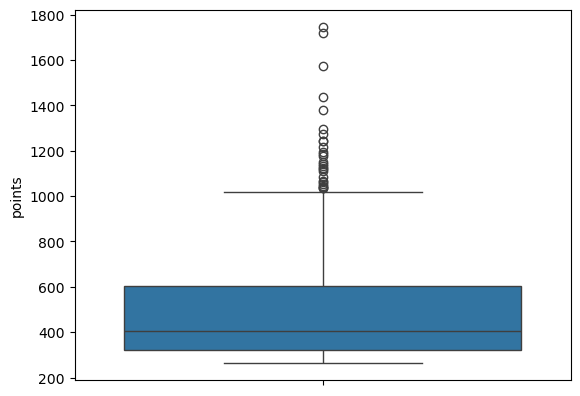

In [47]:
sns.boxplot(y=top_1_percent['points'])

In [25]:
over_1000_points = users_df[users_df['points'] > 1000]
over_1000_points['points'].describe()

count      30.000000
mean     1197.233333
std       196.868534
min      1005.000000
25%      1055.000000
50%      1137.000000
75%      1243.500000
max      1745.000000
Name: points, dtype: float64

<Axes: ylabel='points'>

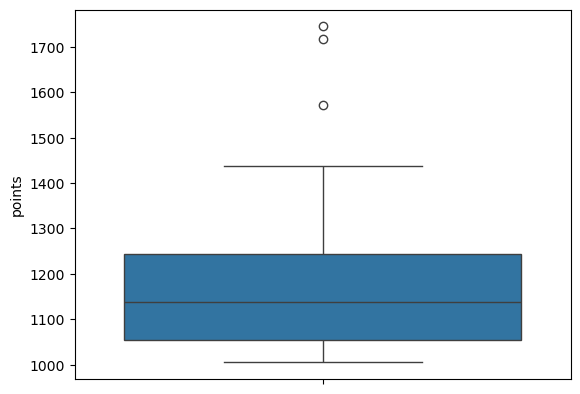

In [51]:
sns.boxplot(y='points', data=over_1000_points)

## Odakle su najbolji igrači, da bismo mogli istraživati sustave u tim državama

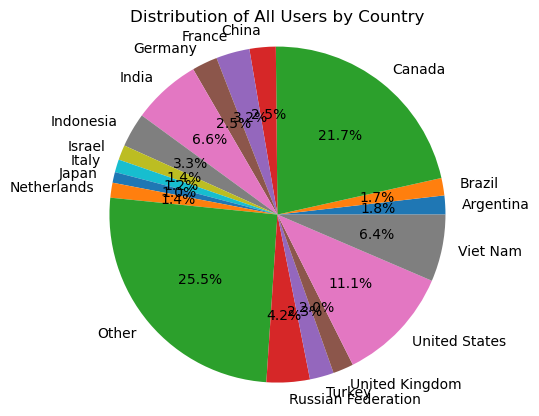

In [ ]:
# Svi igrači
country_counts= users_df['country'].value_counts()

country_labels = country_counts.index.where(country_counts >= 245, 'Other') # više od 1%
country_counts_grouped = country_counts.groupby(country_labels).sum()
plt.pie(country_counts_grouped, labels=country_counts_grouped.index, autopct='%1.1f%%')
plt.title('Distribution of All Users by Country')
plt.axis('equal')
plt.show()

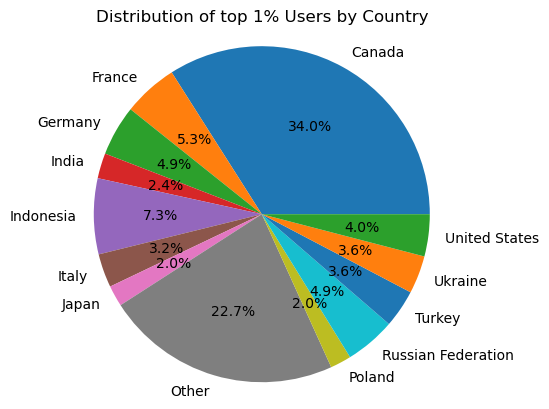

In [ ]:
top_1_percent_country_counts= top_1_percent['country'].value_counts()

country_labels = top_1_percent_country_counts.index.where(top_1_percent_country_counts >= 5, 'Other') # 5 je oko 2%, radi čitljivosti grafa
country_counts_grouped = top_1_percent_country_counts.groupby(country_labels).sum()
plt.pie(country_counts_grouped, labels=country_counts_grouped.index, autopct='%1.1f%%')
plt.title('Distribution of top 1% Users by Country')
plt.axis('equal')
plt.show()

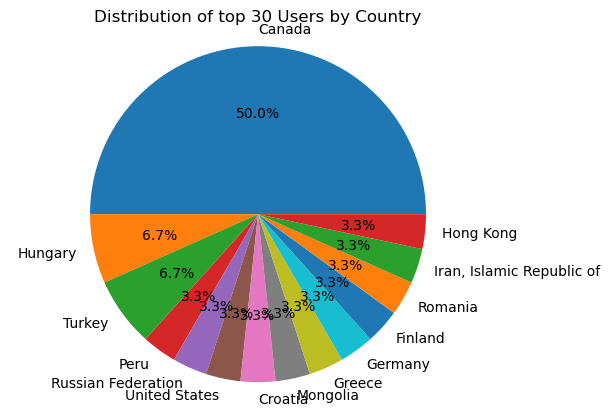

In [93]:
top_30_country_counts= over_1000_points['country'].value_counts()

plt.pie(top_30_country_counts, labels=top_30_country_counts.index, autopct='%1.1f%%')
plt.title('Distribution of top 30 Users by Country')
plt.axis('equal')
plt.show()

## Koliko dugo je najboljim igračima trebalo da dođu do trenutnog broja bodova?

In [ ]:
total_time_1_percent = pd.to_datetime(top_1_percent['last_date']) - pd.to_datetime(top_1_percent['joined_date'])
total_time_1_percent = total_time_1_percent.dt.days / 365.25  # Convert to years
print(total_time_1_percent['total_time'].describe())

count    247.000000
mean       4.034883
std        3.074820
min        0.000000
25%        1.540041
50%        3.488022
75%        6.553046
max       11.351129
dtype: float64


Text(0.5, 1.0, 'Distribution of Total Time in Years for Top 1% Users')

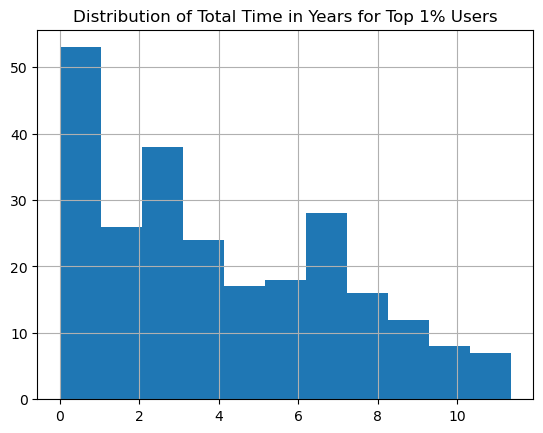

In [109]:
total_time_1_percent.hist(bins=11)
plt.title('Distribution of Total Time in Years for Top 1% Users')

count    30.000000
mean      6.456947
std       2.649556
min       0.224504
25%       4.621492
50%       6.677618
75%       8.314853
max      10.825462
dtype: float64


Text(0.5, 1.0, 'Distribution of Total Time in Years for Top 30 Users')

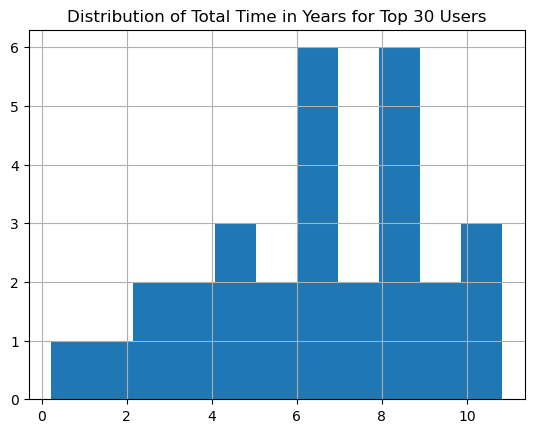

In [110]:
total_time_top_30 = pd.to_datetime(over_1000_points['last_date']) - pd.to_datetime(over_1000_points['joined_date'])
total_time_top_30 = total_time_top_30.dt.days / 365.25  # Convert to years
print(total_time_top_30.describe())
total_time_top_30.hist(bins=11)
plt.title('Distribution of Total Time in Years for Top 30 Users')

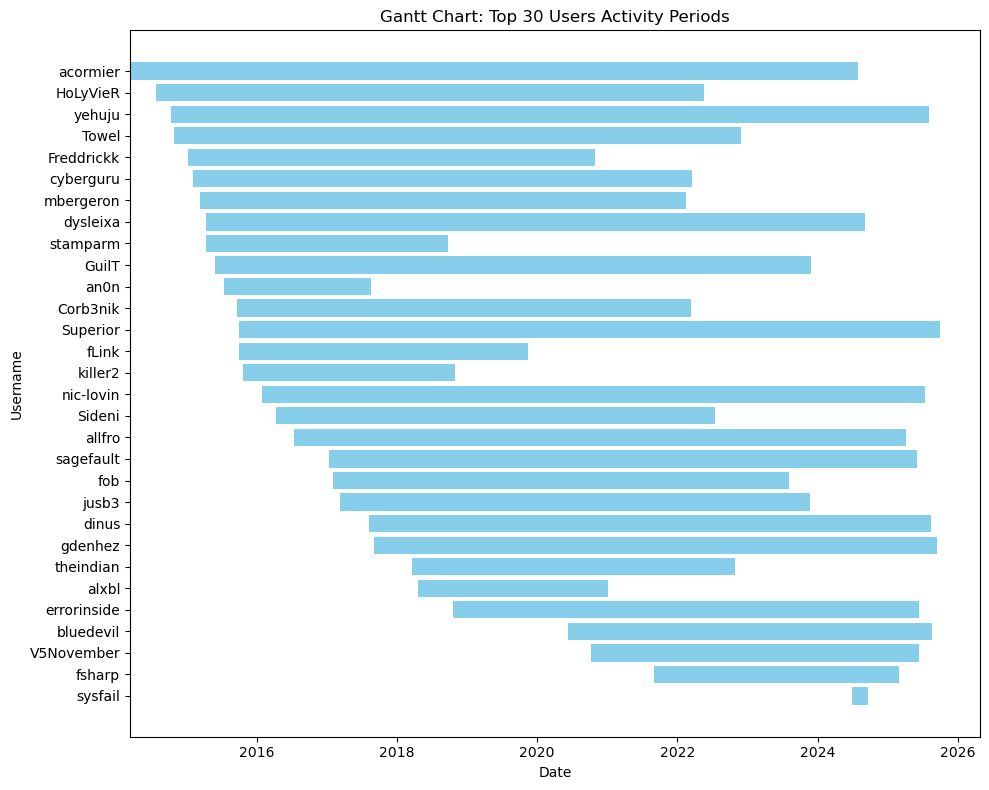

In [114]:
import plotly.express as px

# Prepare the data
gantt_df = over_1000_points.copy()
gantt_df['Start'] = pd.to_datetime(gantt_df['joined_date'])
gantt_df['Finish'] = pd.to_datetime(gantt_df['last_date'])
gantt_df = gantt_df.sort_values('Start')
# Plot Gantt chart using matplotlib
plt.figure(figsize=(10, 8))
for i, row in enumerate(gantt_df.itertuples()):
    plt.barh(row.username, (row.Finish - row.Start).days, left=row.Start, color='skyblue')
plt.xlabel('Date')
plt.ylabel('Username')
plt.title('Gantt Chart: Top 30 Users Activity Periods')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

/tmp/ipykernel_9433/1505068671.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_9433/1505068671.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_9433/1505068671.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



          username  active_years  points
51        acormier     10.392882  1184.0
316       HoLyVieR      7.824778  1041.0
452         yehuju     10.825462  1119.0
493          Towel      8.093087  1272.0
685     Freddrickk      5.804244  1242.0
779      cyberguru      7.118412  1176.0
982      mbergeron      6.932238  1218.0
1222      dysleixa      9.401780  1572.0
1227      stamparm      3.463381  1194.0
1538         GuilT      8.498289  1036.0
1804          an0n      2.099932  1124.0
2287      Corb3nik      6.472279  1437.0
2353      Superior      9.993155  1297.0
2366         fLink      4.114990  1019.0
2466       killer2      3.022587  1005.0
3174     nic-lovin      9.456537  1131.0
3693        Sideni      6.269678  1380.0
4504        allfro      8.733744  1085.0
6014     sagefault      8.388775  1745.0
6146           fob      6.502396  1068.0
6415         jusb3      6.707734  1718.0
7778         dinus      8.008214  1109.0
7948       gdenhez      8.032854  1008.0
9366     theindi

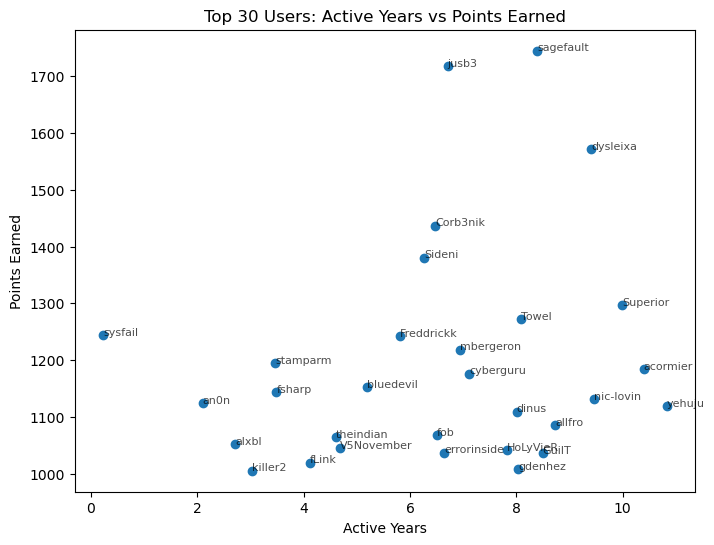

In [ ]:
# Calculate time in years for each user
over_1000_points['Start'] = pd.to_datetime(over_1000_points['joined_date'])
over_1000_points['Finish'] = pd.to_datetime(over_1000_points['last_date'])
over_1000_points['active_years'] = (over_1000_points['Finish'] - over_1000_points['Start']).dt.days / 365.25

# Create a DataFrame with 'active_years' and 'points'
year_points_matrix_df = over_1000_points[['username', 'active_years', 'points']]

print(year_points_matrix_df)

plt.figure(figsize=(8,6))
plt.scatter(year_points_matrix_df['active_years'], year_points_matrix_df['points'])
for i, row in year_points_matrix_df.iterrows():
    plt.annotate(row['username'], (row['active_years'], row['points']), fontsize=8, alpha=0.7)

plt.xlabel('Active Years')
plt.ylabel('Points Earned')
plt.title('Top 30 Users: Active Years vs Points Earned')
plt.show()

## Koje zadatke i kojim redoslijedom su rješavali najbolji korisnici?

Sagefault je očito riješio (skoro) sve zadatke - znači mora biti svestran
Ostali?

In [78]:
# želim dijagram koji prikazuje kako je sagefault rješavao pojeidne kategorije zadataka kroz godine

solve_df = solve_df.merge(challenges_df[['challenge_id', 'overarching_category']], on='challenge_id', how='left')
solve_df['year'] = pd.to_datetime(solve_df['validation_time']).dt.year

sagefault_id = users_df[users_df['username'] == 'sagefault']['id'].values[0]
sagefault_solves = solve_df[solve_df['user_id'] == sagefault_id]
sagefault_solves.head() 

,challenge_id,user_id,validation_time,month,overarching_category,year
7279,1,14785,2017-04-21 12:22:56,4,Web,2017
14341,2,14785,2017-04-21 12:34:48,4,Web,2017
19236,3,14785,2017-04-21 12:58:29,4,Web,2017
22372,171,14785,2017-12-18 20:49:21,12,Web,2017
24965,21,14785,2017-04-24 12:54:43,4,Web,2017


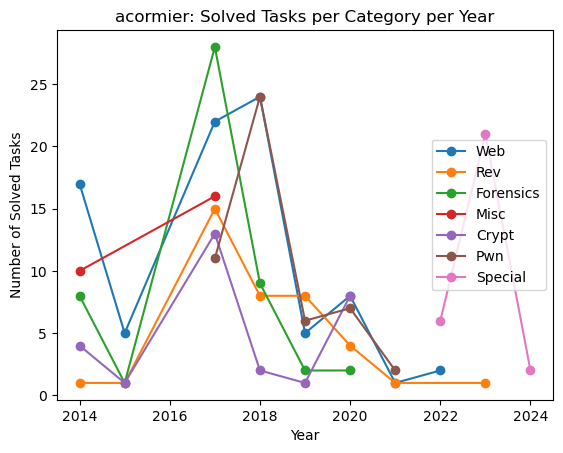

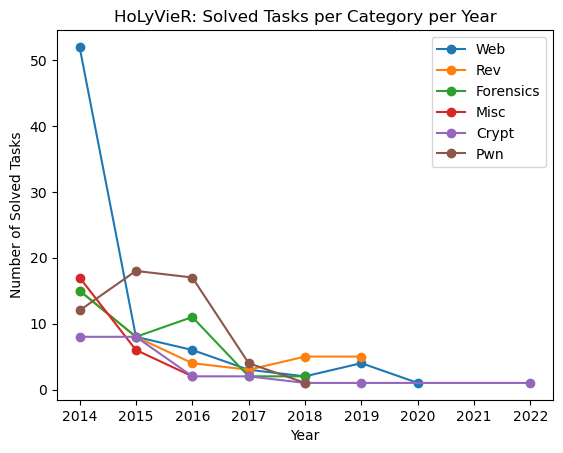

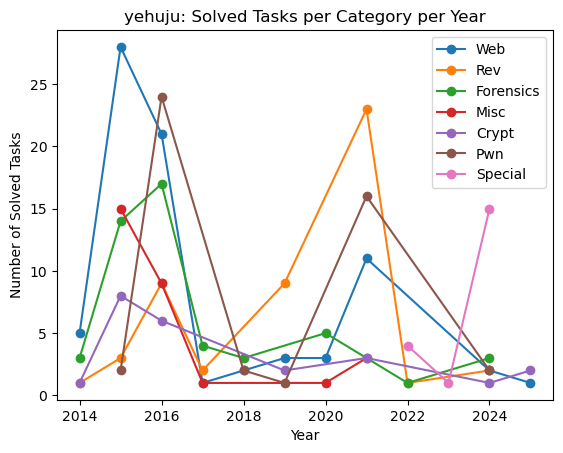

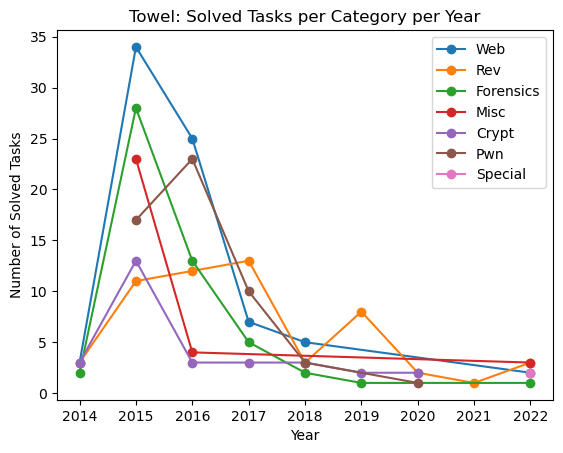

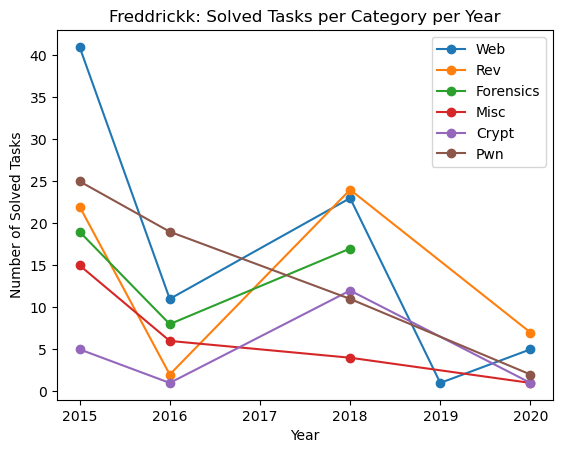

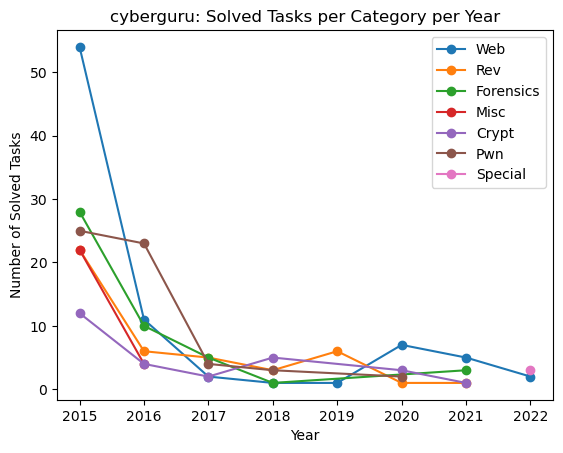

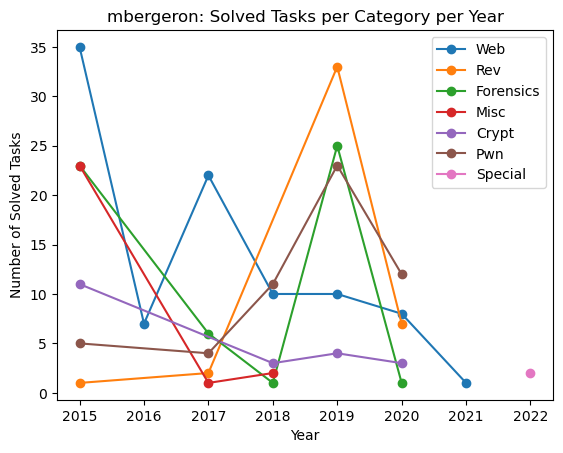

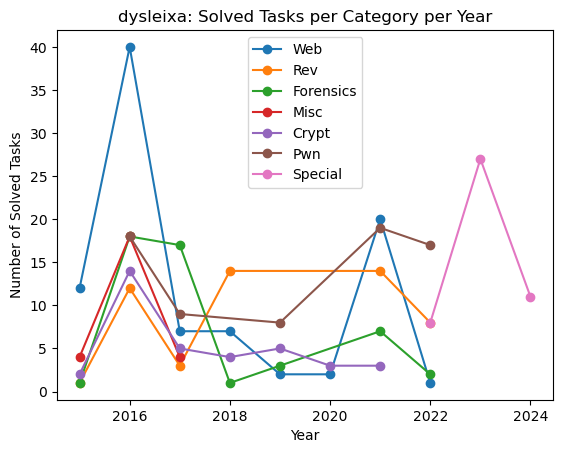

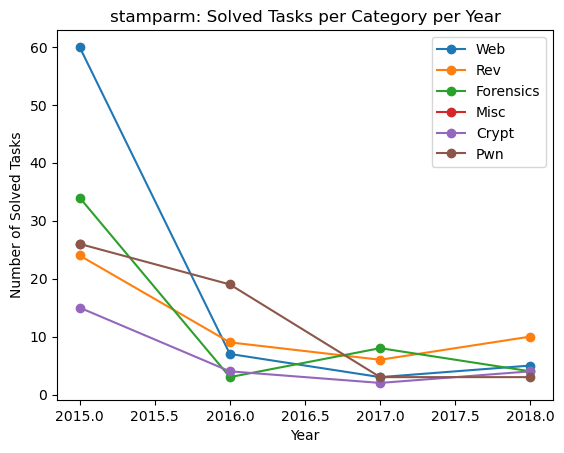

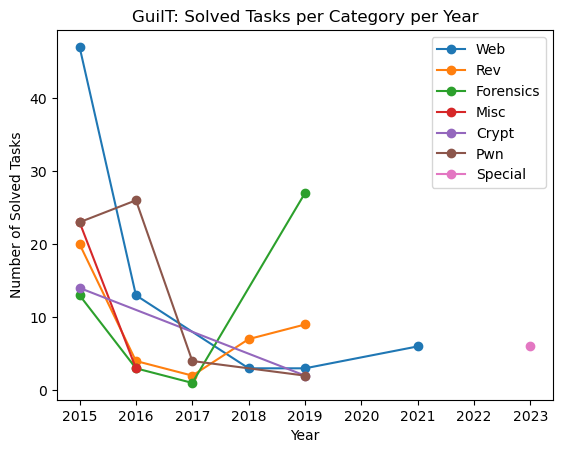

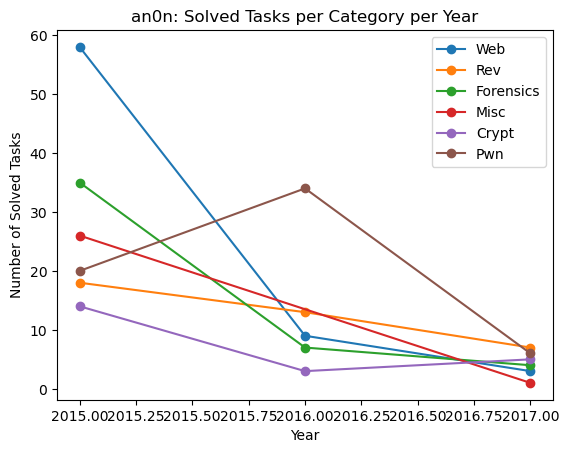

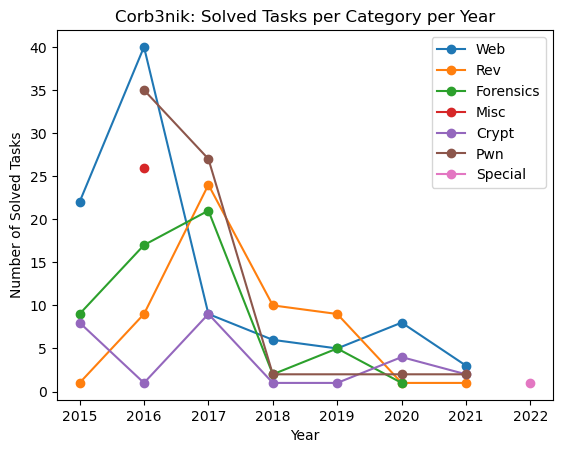

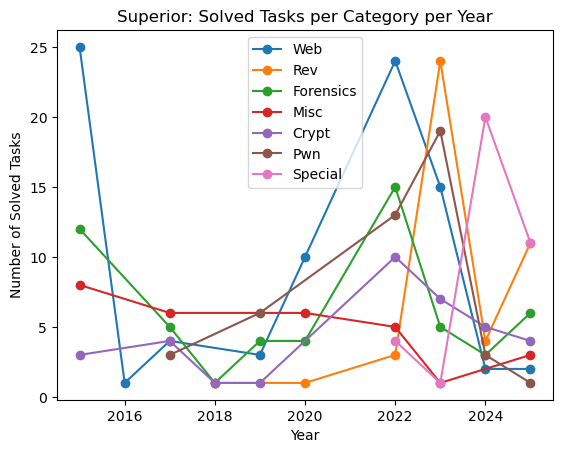

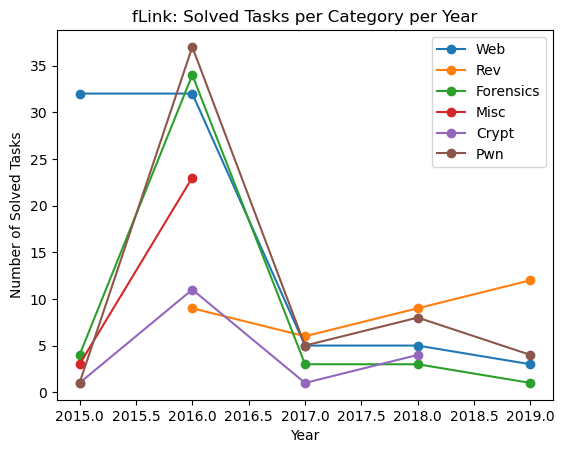

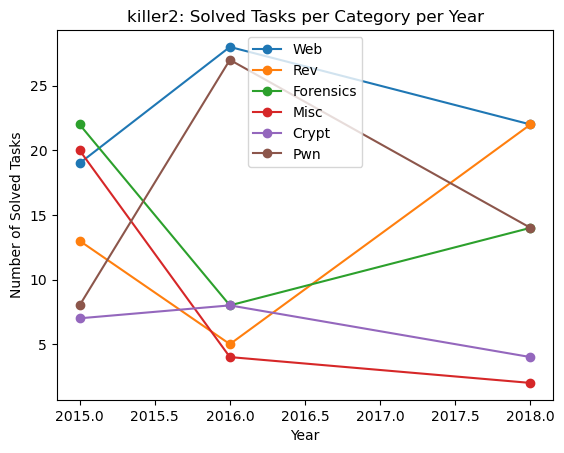

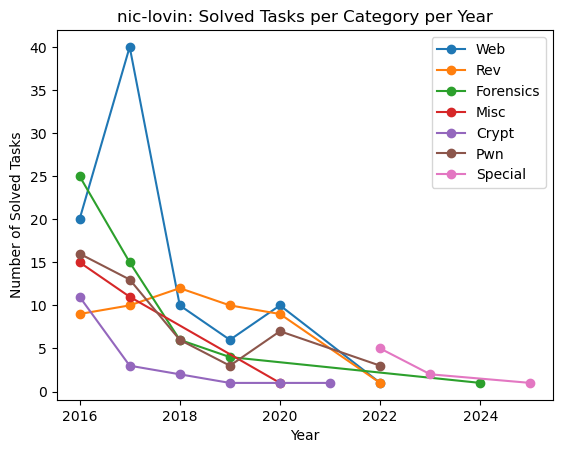

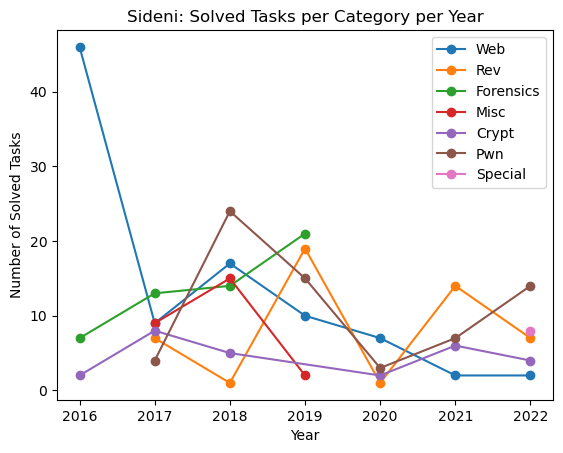

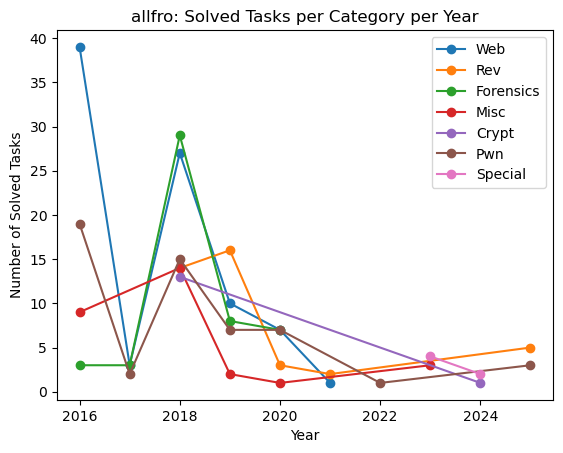

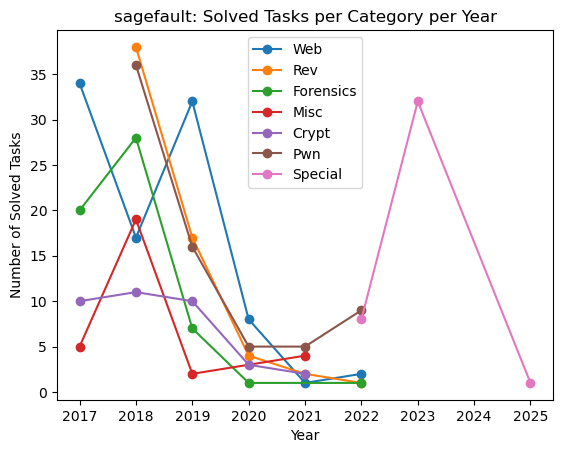

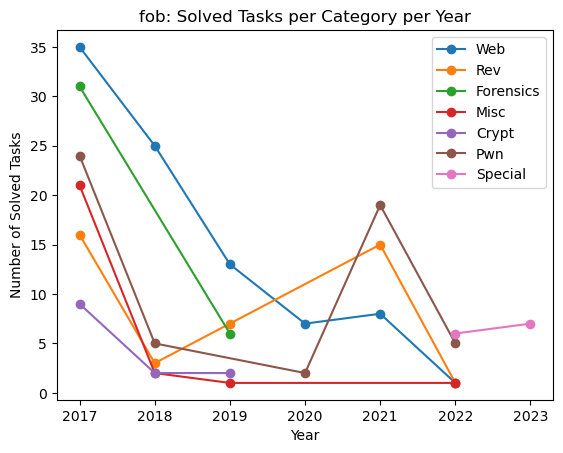

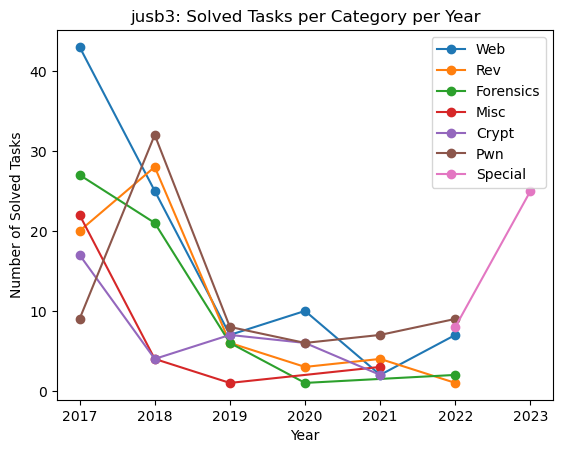

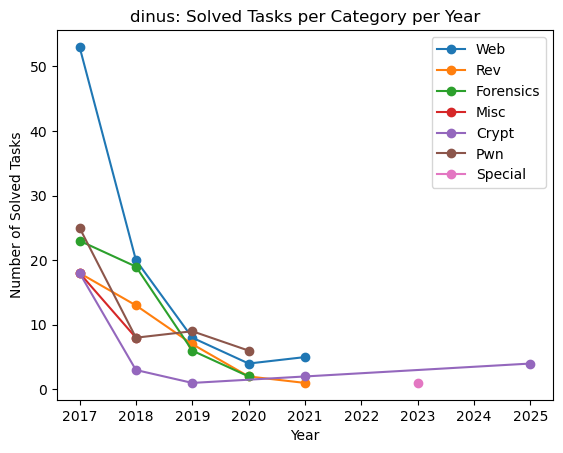

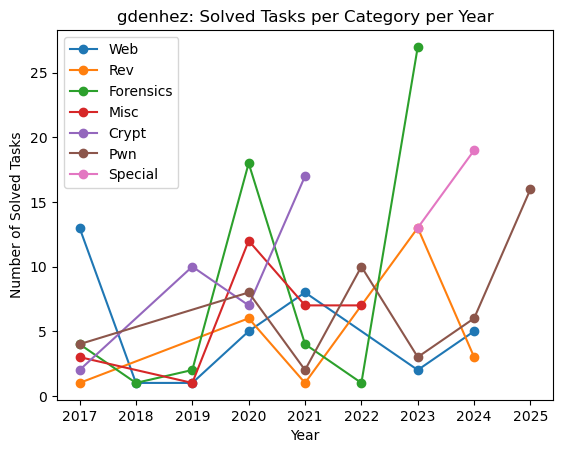

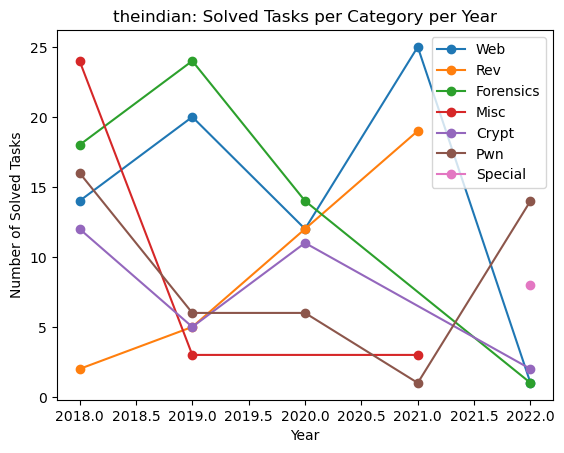

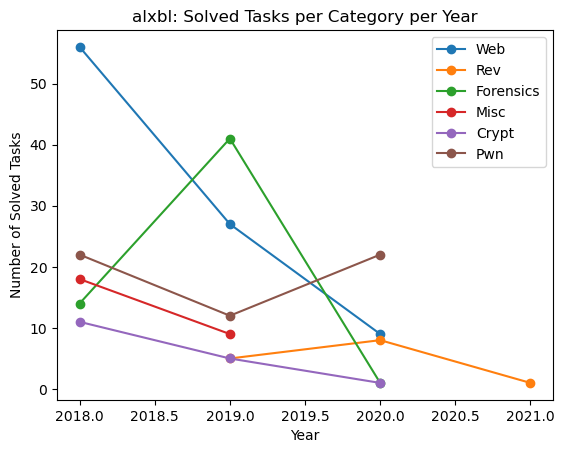

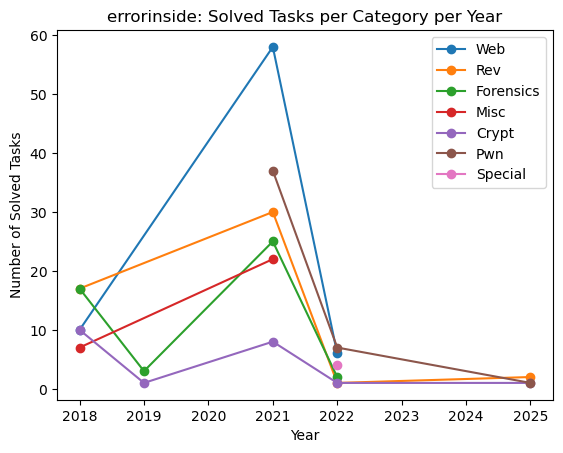

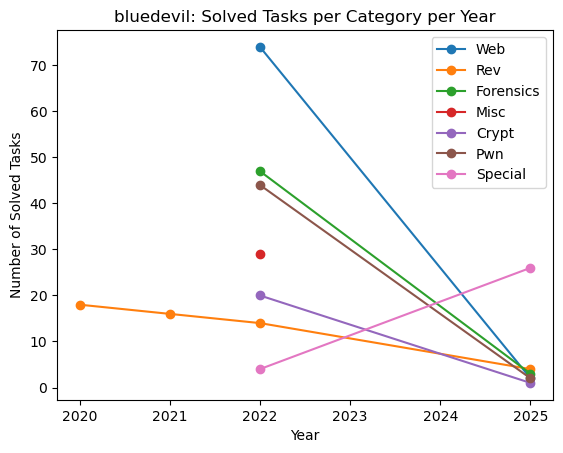

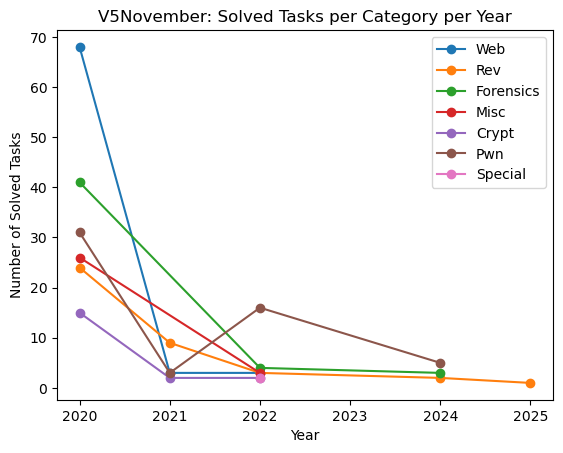

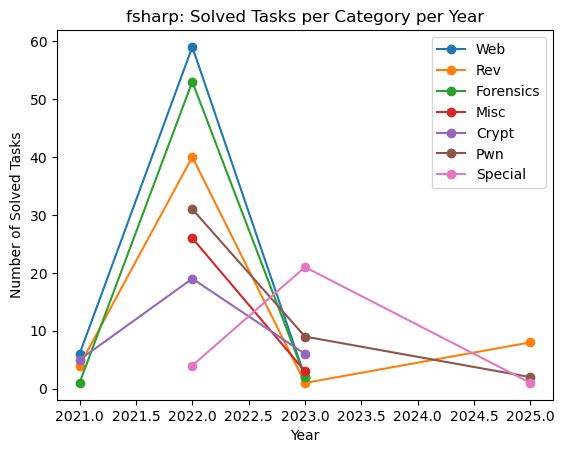

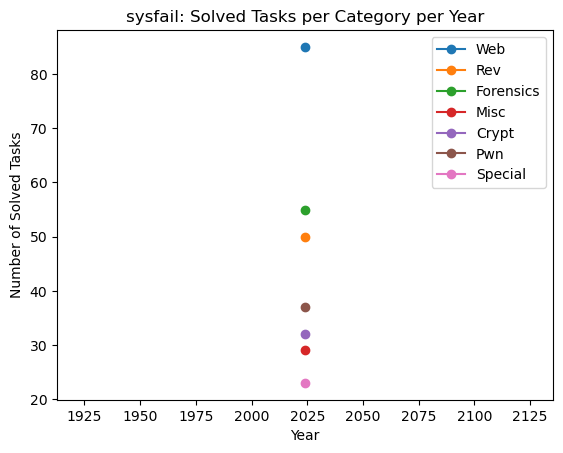

In [ ]:
# graf rasporeda sagefaultovih solveova grupiranih po kategoriji kroz vrijeme
# graf koji prikazuje broj riješenih zadataka iz pojedine kategorije za svaku godinu
for id in over_1000_points['id']:
    username = over_1000_points[over_1000_points['id'] == id]['username'].values[0]
    user_solves = solve_df[solve_df['user_id'] == id]

    plt.figure()
    for category in user_solves['overarching_category'].unique():
        category_solves = user_solves[user_solves['overarching_category'] == category].groupby(['year']).size()
        plt.plot(category_solves.index, category_solves.values, marker='o', label=category)
    
    plt.xlabel('Year')
    plt.ylabel('Number of Solved Tasks')
    plt.title(f'{username}: Solved Tasks per Category per Year')
    plt.legend()
    plt.show()


### Najviši mogući broj bodova koje se može postići u pojedinoj kategoriji

In [19]:
max_points_per_category = challenges_df.groupby('overarching_category')['challenge_points'].sum().reset_index()
max_points_per_category

,overarching_category,challenge_points
0,Crypt,191
1,Forensics,185
2,Misc,123
3,Pwn,337
4,Rev,366
5,Special,218
6,Web,420


In [ ]:
# zelim pronaci ljude koji su najbolji u jednoj kategoriji
users_minimal = users_df[['id', 'rank', 'username']].rename(columns={'id': 'user_id'})
challenges_minimal = challenges_df[['challenge_id', 'overarching_category', 'challenge_points']]
solves_merged_df = solve_df.merge(challenges_minimal, on='challenge_id').merge(users_minimal, on='user_id')
solves_merged_df.head()

,challenge_id,user_id,validation_time,overarching_category,challenge_points,rank,username
0,1,52826,2025-08-29 15:32:22,Web,1,24634.0,Zaxis
1,1,52806,2025-08-26 12:23:04,Web,1,24631.0,fj374b
2,1,52805,2025-08-26 11:56:27,Web,1,5930.0,Penguin123
3,1,52613,2025-08-22 09:42:06,Web,1,1019.0,itdavidlee
4,1,52721,2025-08-14 07:47:19,Web,1,4367.0,adce626


In [ ]:
grouped_by_category_username = solves_merged_df.groupby(['overarching_category', 'username'], as_index=False)['challenge_points'].sum()
grouped_by_category_username


,overarching_category,username,challenge_points
0,Crypt,-B-,3
1,Crypt,.-..---.--.,3
2,Crypt,...,3
3,Crypt,001kaphy,2
4,Crypt,00YoungJesus,3
...,...,...,...
46518,Web,zzaa106,6
46519,Web,zzh8829,5
46520,Web,zzhhzz,5
46521,Web,zzs0suszz0711,67


## Top 10 igrača u pojedinoj kategoriji

prvo ukupan broj bodova pa postotak

In [39]:
top_10_per_category = grouped_by_category_username.groupby('overarching_category').apply(lambda x: x.nlargest(10, 'challenge_points')).reset_index(drop=True)
points_percentage = top_10_per_category['challenge_points'] /max_points_per_category.set_index('overarching_category').loc[top_10_per_category['overarching_category']]['challenge_points'].values
top_10_per_category['points_percentage'] = points_percentage

/tmp/ipykernel_1456768/2983699587.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  top_10_per_category = grouped_by_category_username.groupby('overarching_category').apply(lambda x: x.nlargest(10, 'challenge_points')).reset_index(drop=True)


In [41]:
for category in top_10_per_category['overarching_category'].unique():
    print(f"Category: {category}")
    category_data = top_10_per_category[top_10_per_category['overarching_category'] == category]
    print(category_data[['username', 'challenge_points', 'points_percentage']])
    

Category: Crypt
      username  challenge_points  points_percentage
0     dysleixa               191           1.000000
1      gdenhez               191           1.000000
2        jusb3               191           1.000000
3    sagefault               191           1.000000
4     Superior               181           0.947644
5      sysfail               163           0.853403
6      madness               161           0.842932
7    lixtelnis               146           0.764398
8        Towel               140           0.732984
9  kasia-tutej               138           0.722513
Category: Forensics
     username  challenge_points  points_percentage
10    gdenhez               185           1.000000
11      jusb3               185           1.000000
12  sagefault               185           1.000000
13  theindian               185           1.000000
14     fsharp               182           0.983784
15      alxbl               180           0.972973
16  mbergeron               180    

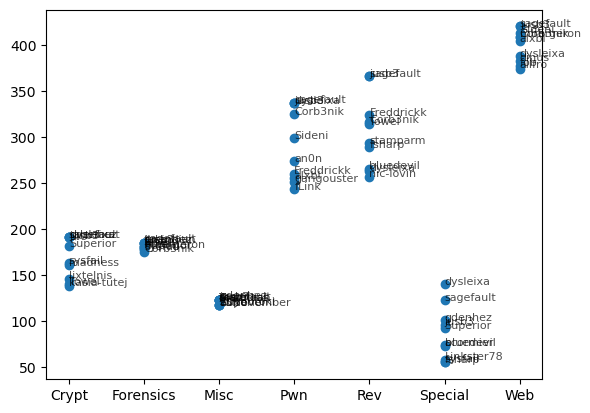

In [61]:
import random
plt.scatter(top_10_per_category['overarching_category'], top_10_per_category['challenge_points'])
for i, row in top_10_per_category.iterrows():
    x = row['overarching_category']
    y = row['challenge_points']
    jittered_y = y + random.uniform(-1, 1)  # small random jitter vertically
    plt.annotate(row['username'], (x, jittered_y), fontsize=8, alpha=0.7)

In [76]:
import plotly.express as px

fig = px.scatter(
    top_10_per_category,
    x='overarching_category',
    y='challenge_points',
    color='username',
    hover_name='username'
)

fig.show()

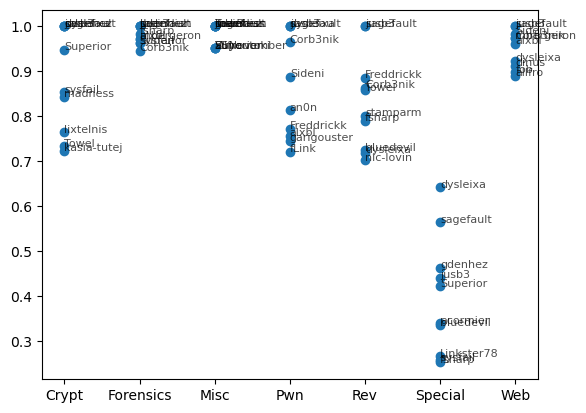

In [ ]:
plt.scatter(top_10_per_category['overarching_category'], top_10_per_category['points_percentage'] )
for i, row in top_10_per_category.iterrows():
    plt.annotate(row['username'], (row['overarching_category'], row['points_percentage']), fontsize=8, alpha=0.7)

U top 10 igrača po svakoj kategoriji javljaju se isljučivo korisnici koji su među 30 najboljih igrača na platformi (preko 1000 bodova)

In [50]:
top_10_per_category[['username']].where(top_10_per_category['username'].isin(over_1000_points['username'])).drop_duplicates()

,username
0,dysleixa
1,gdenhez
2,jusb3
3,sagefault
4,Superior
5,sysfail
6,NaN
8,Towel
13,theindian
14,fsharp


In [57]:
# želim među najboljijma u pojedinoj kategoriji vidjeti koji od njih su među top 30 u svim kategorijama
cross_section = top_10_per_category[top_10_per_category['username'].isin(over_1000_points['username'])].groupby('username')['overarching_category'].unique().reset_index(name='category_points')
cross_section

,username,category_points
0,Corb3nik,"[Forensics, Pwn, Rev, Web]"
1,Freddrickk,"[Pwn, Rev]"
2,Sideni,"[Pwn, Web]"
3,Superior,"[Crypt, Forensics, Misc, Special]"
4,Towel,"[Crypt, Misc, Rev]"
5,V5November,[Misc]
6,acormier,[Special]
7,allfro,"[Misc, Web]"
8,alxbl,"[Forensics, Pwn, Web]"
9,an0n,[Pwn]


In [97]:
n= max(int(len(grouped_by_category_username)* 0.01), 1)
top_1_percent_per_category = grouped_by_category_username.groupby('overarching_category').apply(lambda x: x.nlargest(n, 'challenge_points')).reset_index(drop=True)
points_percentage = top_1_percent_per_category['challenge_points'] / max_points_per_category.set_index('overarching_category').loc[top_10_per_category['overarching_category']]['challenge_points'].values
top_1_percent_per_category['points_percentage'] = points_percentage

/tmp/ipykernel_1456768/1155359555.py:2: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



ValueError: operands could not be broadcast together with shapes (2992,) (70,) 